# Hi :)

----

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

----

# Loading the dataset

In [2]:
# Loading the dataset
SisFall_Dataset= pd.read_csv('Dataset/SisFall_dataset.csv')
# Showing 5 random rows
SisFall_Dataset.sample(5, random_state= 48)

,ADXL345_x,ADXL345_y,ADXL345_z,ITG3200_x,ITG3200_y,ITG3200_z,MMA8451Q_x,MMA8451Q_y,MMA8451Q_z,Situation
636970,3,-237,-149,-120,-122,-96,-78,-881,-437,Fall
734642,-22,59,-283,-43,18,-4,-181,259,-979,Fall
1069635,37,-348,-103,702,-766,437,133,-1329,-305,Not Fall
793919,279,41,-3,-28,46,-10,982,172,153,Fall
541529,7,-429,-144,-295,960,240,-64,-1627,-429,Fall


In [3]:
# Making a copy of original dataset to work with
df= SisFall_Dataset.copy()

# Butterworth filter

Initialization

In [4]:
def butter_lowpass_filter(data, cutoff= 20, fs= 200, order= 4):
    """
    Apply a low-pass Butterworth filter to multichannel inertial data.

    Parameters:
    - data (np.ndarray): shape (n_samples, n_channels)
    - cutoff (float): cutoff frequency in Hz
    - fs (int): sampling frequency in Hz
    - order (int): order of the Butterworth filter

    Returns:
    - filtered_data (np.ndarray): filtered data, same shape as input
    """
    nyq= 0.5 * fs
    normal_cutoff= cutoff / nyq

    # Design filter
    b, a= butter(order, normal_cutoff, btype= 'low', analog= False)

    # Apply zero-phase filtering to each channel
    filtered_data= filtfilt(b, a, data, axis= 0)
    
    return filtered_data

# Visualization
def plot_filtering(raw_data, filtered_data, channel= 0, channel_name= None):
    """
    Plots raw vs. filtered data for a single channel.

    Parameters:
    - raw_data: np.ndarray, shape (n_samples, n_channels)
    - filtered_data: np.ndarray, same shape as raw_data
    - channel: int, index of the channel to plot
    - channel_name: optional str, name of the channel for plot labeling
    """
    plt.figure(figsize= (12, 4))
    plt.plot(raw_data[:, channel], label= 'Raw', alpha= 0.6)
    plt.plot(filtered_data[:, channel], label= 'Filtered', linewidth= 2)
    title= f'Filtering Channel {channel}' if channel_name is None else f'Filtering: {channel_name}'
    plt.title(title)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Filter implementation

In [5]:
signal_columns= df.columns.to_list()[: -1]
raw_signals= df[signal_columns]

# Apply filter only to the signal columns
df[signal_columns]= butter_lowpass_filter(raw_signals.values)

Visualization

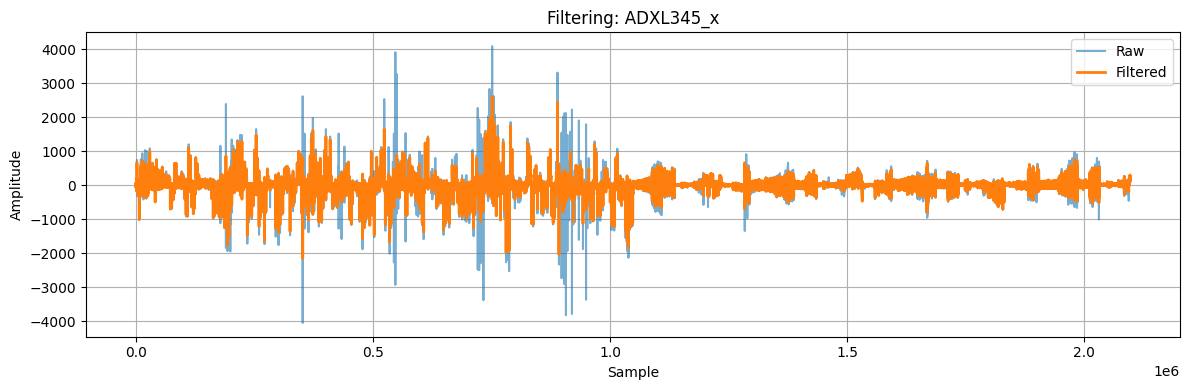

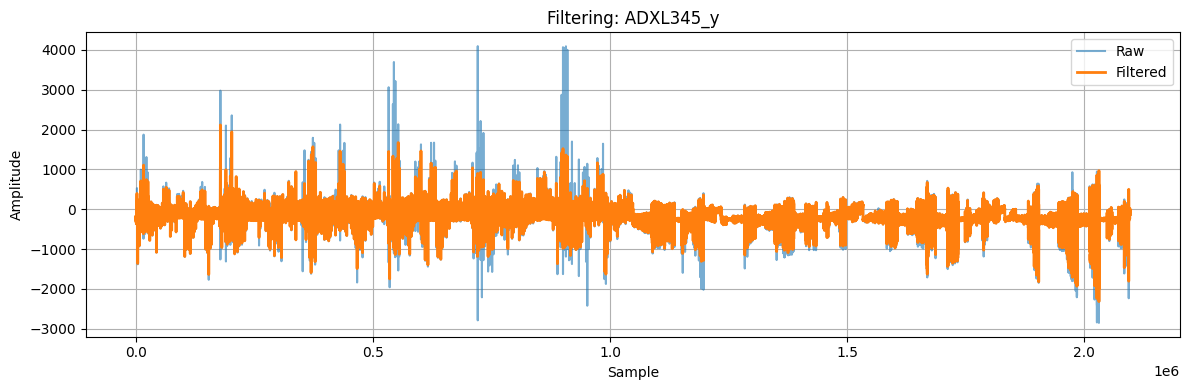

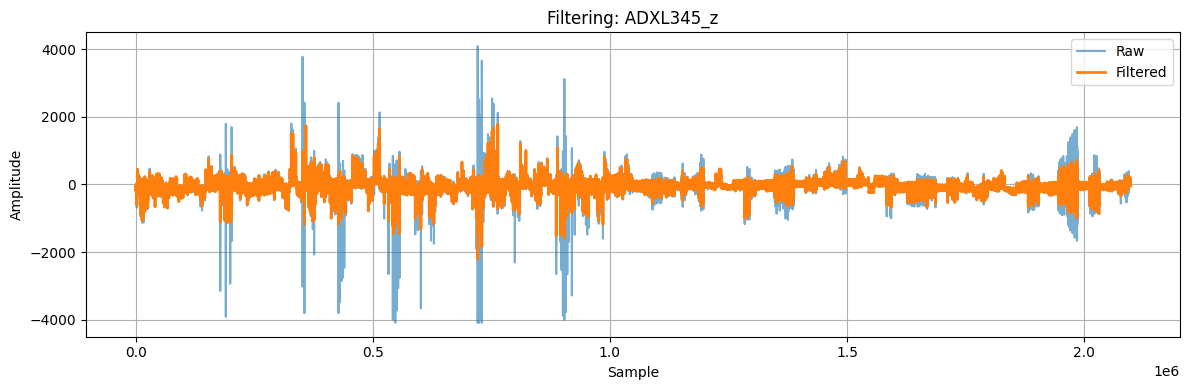

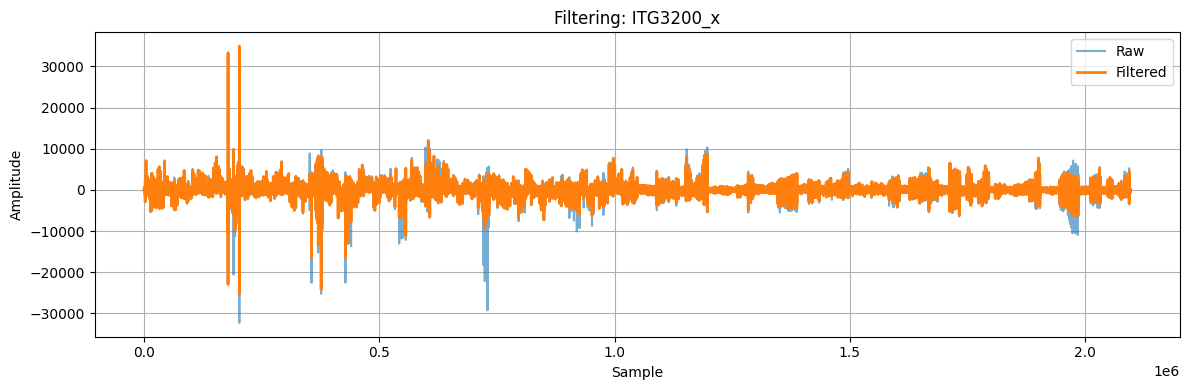

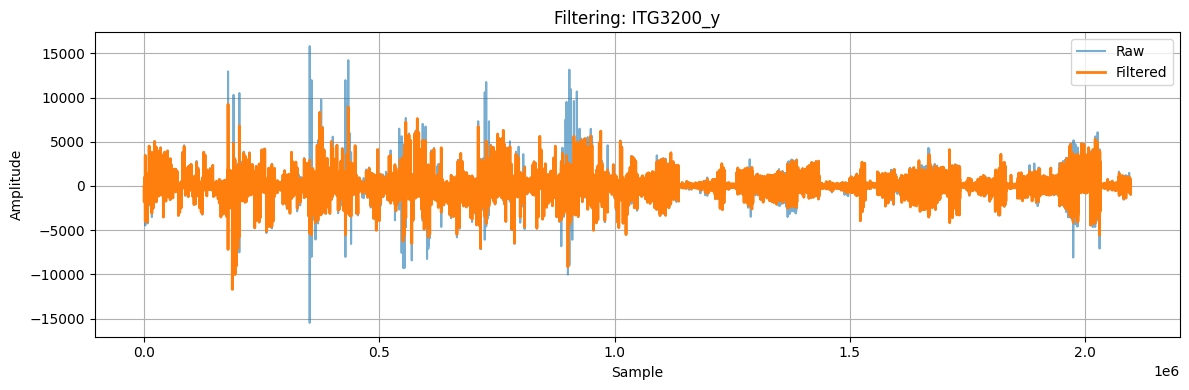

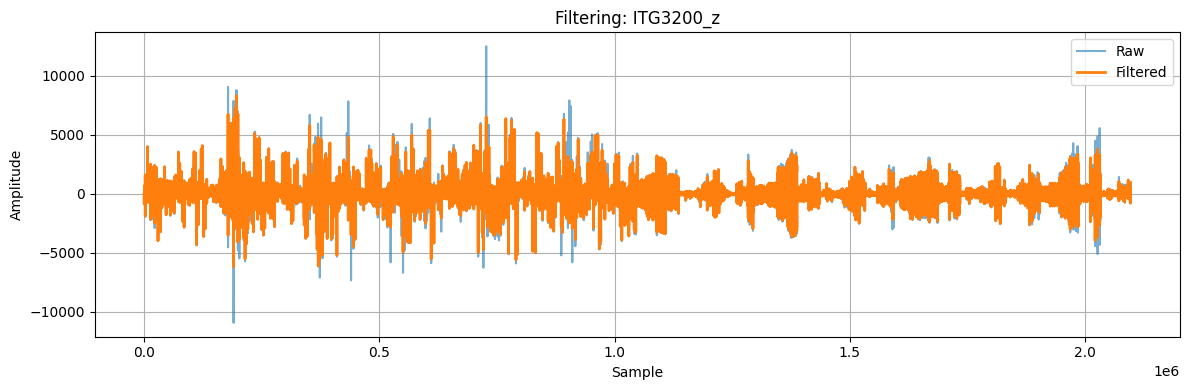

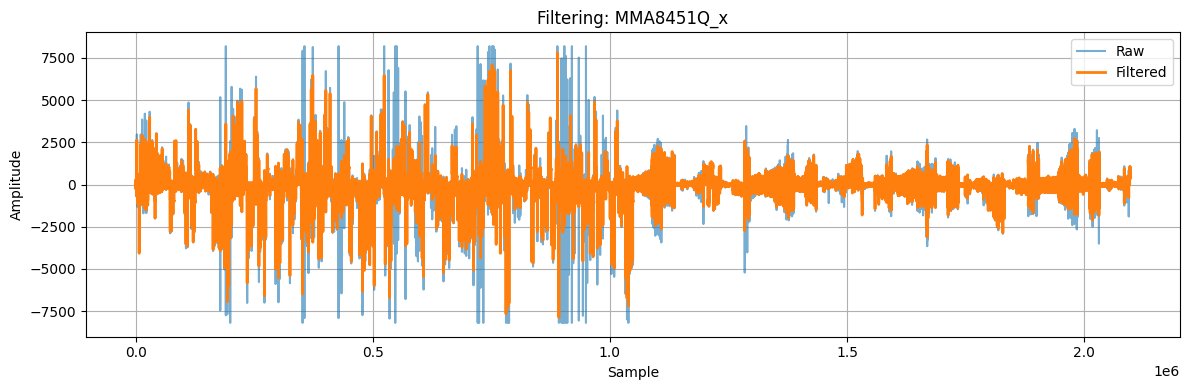

C:\Users\Erfaan_Joodi\AppData\Local\Temp\ipykernel_6332\2324100617.py:45: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


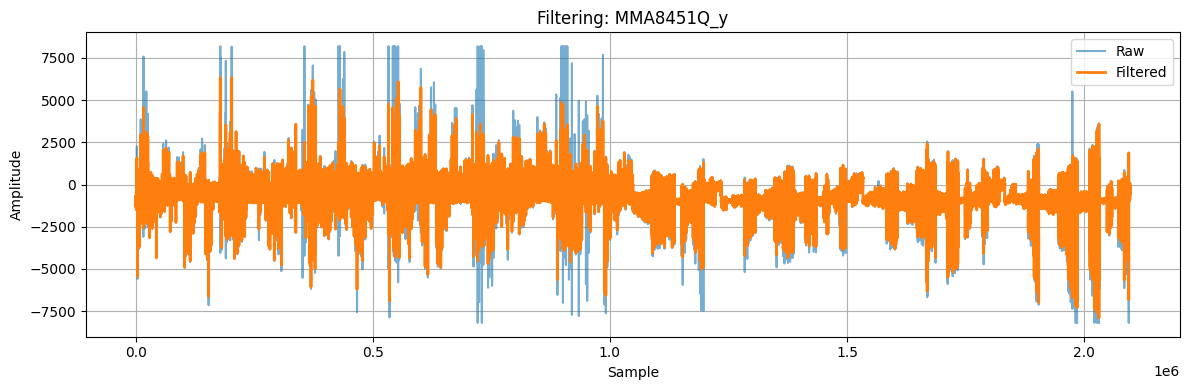

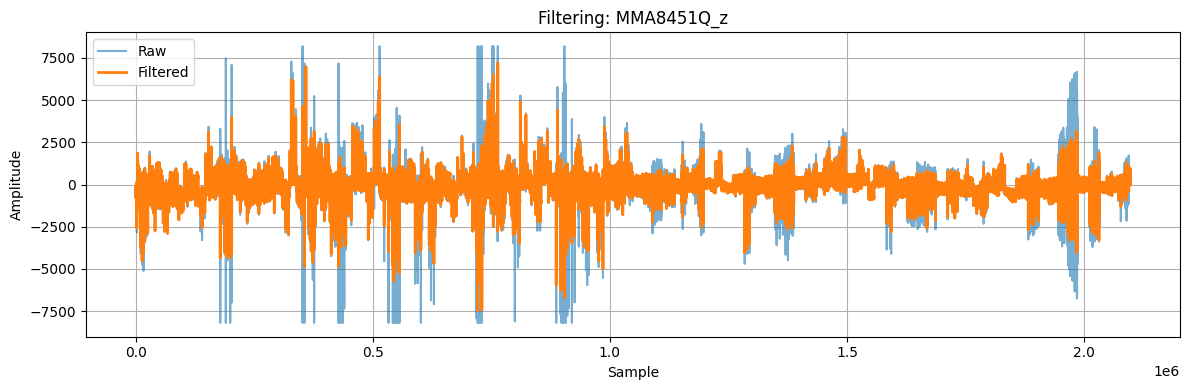

In [6]:
for i, col in enumerate(signal_columns):
    plot_filtering(raw_signals.values, df[signal_columns].values, channel= i, channel_name= col)

# Kalman Filter

Kalman Filter Implementation on three axis

Initialization

In [7]:
# Creating a function to implement Kalman Filter
def run_kalman_filter_vector(measurements, R_value, A, H, Q, x0, P0):
    x= x0.copy()
    P= P0.copy()
    estimates= []

    for z in measurements:
        # Predict
        x= A @ x
        P= A @ P @ A.T + Q

        # Update
        y= np.array(z).reshape(-1, 1) - H @ x
        S= H @ P @ H.T + R_value
        K= P @ H.T @ np.linalg.inv(S)
        x= x + K @ y
        P= (np.eye(P.shape[0]) - K @ H) @ P

        estimates.append(x.flatten())  # Store estimated state

    return estimates

In [8]:
A= np.eye(3)   # No dynamics for now
Q= np.eye(3) * 0.001
x0= np.zeros((3, 1))
P0= np.eye(3)

# Same H matrix as above
H= np.array([
    [1, 0, 0], [0, 1, 0], [0, 0, 1],  # accel1
    [1, 0, 0], [0, 1, 0], [0, 0, 1],  # accel2
    [1, 0, 0], [0, 1, 0], [0, 0, 1],  # gyro
])

R= np.diag([0.05] * 6 + [0.1] * 3)  # More trust in accelerometers

In [9]:
# Getting the measurements a specific order for Kalman Filter implementation
measurements= df[['ADXL345_x', 'ADXL345_y', 'ADXL345_z', 'MMA8451Q_x', 'MMA8451Q_y', 'MMA8451Q_z', 'ITG3200_x', 'ITG3200_y', 'ITG3200_z']].values

Kalman Filter Main loop

In [10]:
estimates= run_kalman_filter_vector(measurements, R, A, H, Q, x0, P0)

Adding Kalman Filter data to dataset

In [11]:
# Adding Kalman Filter data
df[['x_kalman', 'y_kalman', 'z_kalman']]=np.array(estimates).round(2)
# Fixing the dataset columns
df= df[[col for col in df.columns if col != 'Situation'] + ['Situation']]

# Feature Calculation

ITG data

In [12]:
window_size= 200
overlap= 100
stride= window_size - overlap

features= []

# Get signals and labels
a_x= df['ITG3200_x'].values
a_y= df['ITG3200_y'].values
a_z= df['ITG3200_z'].values
situation= df['Situation'].values

num_samples= len(df)
num_windows= (num_samples - window_size) // stride + 1  # excludes partial windows

for i in range(num_windows):
    start= i * stride
    end= start + window_size

    # Check if full window fits
    if end > num_samples:
        break

    # Extract window data
    window_ax= a_x[start : end]
    window_ay= a_y[start : end]
    window_az= a_z[start : end]
    window_situation= situation[start : end]

    # --- Condition 1: Ensure situation is consistent in window ---
    if len(set(window_situation)) > 1:
        continue  # skip this window

    # --- F1: Sum vector magnitude (RMS) ---
    magnitudes= np.sqrt(window_ax**2 + window_ay**2 + window_az**2)
    F1= np.mean(magnitudes).round(2)

    # --- F2: Orientation angle ---
    angles= np.arctan2(np.sqrt(window_ax**2 + window_az**2), -window_ay)
    F2= np.mean(angles).round(2)

    # --- F3: Std deviation magnitude ---
    std_x= np.std(window_ax)
    std_y= np.std(window_ay)
    std_z= np.std(window_az)
    F3= np.sqrt(std_x**2 + std_y**2 + std_z**2).round(2)

    # Get window label (same for all rows in valid window)
    label= window_situation[0]

    # Store feature and label
    features.append([F1, F2, F3, label, start])

# Convert to DataFrame
ITG_features_df= pd.DataFrame(features, columns= [
    'F1_sum_vector_magnitude',
    'F2_orientation_angle',
    'F3_std_magnitude',
    'Situation',
    'window_start_index'
])

# Save the DataFrame
ITG_features_df.to_csv('Dataset/ITG_features_df.csv')

Kalman Filter data

In [13]:
window_size= 200
overlap= 100
stride= window_size - overlap

features= []

# Get signals and labels
a_x= df['x_kalman'].values
a_y= df['y_kalman'].values
a_z= df['z_kalman'].values
situation= df['Situation'].values

num_samples= len(df)
num_windows= (num_samples - window_size) // stride + 1  # excludes partial windows

for i in range(num_windows):
    start= i * stride
    end= start + window_size

    # Check if full window fits
    if end > num_samples:
        break

    # Extract window data
    window_ax= a_x[start : end]
    window_ay= a_y[start : end]
    window_az= a_z[start : end]
    window_situation= situation[start : end]

    # --- Condition 1: Ensure situation is consistent in window ---
    if len(set(window_situation)) > 1:
        continue  # skip this window

    # --- F1: Sum vector magnitude (RMS) ---
    magnitudes= np.sqrt(window_ax**2 + window_ay**2 + window_az**2)
    F1= np.mean(magnitudes).round(2)

    # --- F2: Orientation angle ---
    angles= np.arctan2(np.sqrt(window_ax**2 + window_az**2), -window_ay)
    F2= np.mean(angles).round(2)

    # --- F3: Std deviation magnitude ---
    std_x= np.std(window_ax)
    std_y= np.std(window_ay)
    std_z= np.std(window_az)
    F3= np.sqrt(std_x**2 + std_y**2 + std_z**2).round(2)

    # Get window label (same for all rows in valid window)
    label= window_situation[0]

    # Store feature and label
    features.append([F1, F2, F3, label, start])

# Convert to DataFrame
KF_features_df= pd.DataFrame(features, columns= [
    'F1_sum_vector_magnitude',
    'F2_orientation_angle',
    'F3_std_magnitude',
    'Situation',
    'window_start_index'
])

# Save the DataFrame
KF_features_df.to_csv('Dataset/KF_features_df.csv')